In [1]:
import csv
import sqlite3

# Create a connection to the SQLite database
conn = sqlite3.connect('shopping_trends.db')
cursor = conn.cursor()

# Create tables
cursor.execute('''CREATE TABLE IF NOT EXISTS Customers
                  (CustomerID INTEGER PRIMARY KEY, Age INTEGER, Gender TEXT)''')

cursor.execute('''CREATE TABLE IF NOT EXISTS Products
                  (ProductID INTEGER PRIMARY KEY AUTOINCREMENT, 
                   ItemName TEXT, Category TEXT, Size TEXT, Color TEXT)''')

cursor.execute('''CREATE TABLE IF NOT EXISTS Locations
                  (LocationID INTEGER PRIMARY KEY AUTOINCREMENT, 
                   LocationName TEXT UNIQUE)''')

cursor.execute('''CREATE TABLE IF NOT EXISTS Seasons
                  (SeasonID INTEGER PRIMARY KEY AUTOINCREMENT, 
                   SeasonName TEXT UNIQUE)''')

cursor.execute('''CREATE TABLE IF NOT EXISTS Purchases
                  (PurchaseID INTEGER PRIMARY KEY AUTOINCREMENT,
                   CustomerID INTEGER,
                   ProductID INTEGER,
                   LocationID INTEGER,
                   SeasonID INTEGER,
                   PurchaseAmount REAL,
                   ReviewRating REAL,
                   SubscriptionStatus TEXT,
                   PaymentMethod TEXT,
                   ShippingType TEXT,
                   DiscountApplied TEXT,
                   PromoCodeUsed TEXT,
                   PreviousPurchases INTEGER,
                   PreferredPaymentMethod TEXT,
                   FrequencyOfPurchases TEXT,
                   FOREIGN KEY (CustomerID) REFERENCES Customers(CustomerID),
                   FOREIGN KEY (ProductID) REFERENCES Products(ProductID),
                   FOREIGN KEY (LocationID) REFERENCES Locations(LocationID),
                   FOREIGN KEY (SeasonID) REFERENCES Seasons(SeasonID))''')

# Read CSV file and insert data
with open('shopping_trends.csv', 'r') as csvfile:
    csvreader = csv.DictReader(csvfile)
    for row in csvreader:
        # Insert into Customers table
        cursor.execute('''INSERT OR IGNORE INTO Customers (CustomerID, Age, Gender)
                          VALUES (?, ?, ?)''', 
                       (row['Customer ID'], row['Age'], row['Gender']))

        # Insert into Products table
        cursor.execute('''INSERT OR IGNORE INTO Products (ItemName, Category, Size, Color)
                          VALUES (?, ?, ?, ?)''', 
                       (row['Item Purchased'], row['Category'], row['Size'], row['Color']))
        product_id = cursor.lastrowid

        # Insert into Locations table
        cursor.execute('''INSERT OR IGNORE INTO Locations (LocationName)
                          VALUES (?)''', (row['Location'],))
        location_id = cursor.lastrowid or cursor.execute('''SELECT LocationID FROM Locations 
                                                            WHERE LocationName = ?''', 
                                                         (row['Location'],)).fetchone()[0]

        # Insert into Seasons table
        cursor.execute('''INSERT OR IGNORE INTO Seasons (SeasonName)
                          VALUES (?)''', (row['Season'],))
        season_id = cursor.lastrowid or cursor.execute('''SELECT SeasonID FROM Seasons 
                                                          WHERE SeasonName = ?''', 
                                                       (row['Season'],)).fetchone()[0]

        # Insert into Purchases table
        cursor.execute('''INSERT INTO Purchases 
                          (CustomerID, ProductID, LocationID, SeasonID, PurchaseAmount, 
                           ReviewRating, SubscriptionStatus, PaymentMethod, ShippingType, 
                           DiscountApplied, PromoCodeUsed, PreviousPurchases, 
                           PreferredPaymentMethod, FrequencyOfPurchases)
                          VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''',
                       (row['Customer ID'], product_id, location_id, season_id,
                        row['Purchase Amount (USD)'], row['Review Rating'],
                        row['Subscription Status'], row['Payment Method'],
                        row['Shipping Type'], row['Discount Applied'],
                        row['Promo Code Used'], row['Previous Purchases'],
                        row['Preferred Payment Method'], row['Frequency of Purchases']))

# Commit changes and close connection
conn.commit()
conn.close()


In [2]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect('shopping_trends.db')

# SQL query to join the tables
query = """
SELECT 
    c.CustomerID,
    c.Age,
    c.Gender,
    p.ItemName AS Product,
    p.Category,
    p.Size,
    p.Color,
    l.LocationName AS Location,
    s.SeasonName AS Season,
    pu.PurchaseAmount,
    pu.ReviewRating,
    pu.SubscriptionStatus,
    pu.PaymentMethod,
    pu.ShippingType,
    pu.DiscountApplied,
    pu.PromoCodeUsed,
    pu.PreviousPurchases,
    pu.PreferredPaymentMethod,
    pu.FrequencyOfPurchases
FROM Purchases pu
JOIN Customers c ON pu.CustomerID = c.CustomerID
JOIN Products p ON pu.ProductID = p.ProductID
JOIN Locations l ON pu.LocationID = l.LocationID
JOIN Seasons s ON pu.SeasonID = s.SeasonID
"""

# Execute the query and load the results into a Pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Display the first few rows of the DataFrame
print(df.head())


   CustomerID  Age Gender   Product  Category Size   Color       Location  \
0           1   55   Male    Blouse  Clothing    L    Gray       Kentucky   
1           3   50   Male     Jeans  Clothing    S  Maroon  Massachusetts   
2           6   46   Male  Sneakers  Footwear    M   White        Wyoming   
3           7   63   Male     Shirt  Clothing    M    Gray        Montana   

   Season  PurchaseAmount  ReviewRating SubscriptionStatus PaymentMethod  \
0  Winter            53.0           3.1                Yes   Credit Card   
1  Spring            73.0           3.1                Yes          Cash   
2  Summer            20.0           2.9                Yes         Venmo   
3    Fall            85.0           3.2                Yes    Debit Card   

    ShippingType DiscountApplied PromoCodeUsed  PreviousPurchases  \
0        Express             Yes           Yes                 14   
1  Free Shipping             Yes           Yes                 23   
2       Standard          

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_csv('shopping_trends.csv')

# Display distribution of key categorical variables
print("Gender distribution:")
print(df['Gender'].value_counts(normalize=True))

print("\nCategory distribution:")
print(df['Category'].value_counts(normalize=True))

print("\nSeason distribution:")
print(df['Season'].value_counts(normalize=True))

print("\nSubscription Status distribution:")
print(df['Subscription Status'].value_counts(normalize=True))


Gender distribution:
Gender
Male      0.68
Female    0.32
Name: proportion, dtype: float64

Category distribution:
Category
Clothing       0.445385
Accessories    0.317949
Footwear       0.153590
Outerwear      0.083077
Name: proportion, dtype: float64

Season distribution:
Season
Spring    0.256154
Fall      0.250000
Winter    0.248974
Summer    0.244872
Name: proportion, dtype: float64

Subscription Status distribution:
Subscription Status
No     0.73
Yes    0.27
Name: proportion, dtype: float64


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and explore the dataset
df = pd.read_csv("shopping_trends.csv")

# Display dataset information
print("Dataset Info:")
df.info()

# Check missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Get summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Create correlation matrix for numerical features only
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numerical_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Create distribution plots for numerical features
for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Check unique values in categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\nUnique values in {col}:")
    print(df[col].value_counts())

# Create data cleanup tasks list
print("\nData Cleanup Tasks:")
print("1. Handle any missing values if found")
print("2. Check for outliers in numerical features")
print("3. Encode categorical variables")
print("4. Scale numerical features")
print("5. Handle any capped values in Review Rating")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               3900 non-null   int64  
 1   Age                       3900 non-null   int64  
 2   Gender                    3900 non-null   object 
 3   Item Purchased            3900 non-null   object 
 4   Category                  3900 non-null   object 
 5   Purchase Amount (USD)     3900 non-null   int64  
 6   Location                  3900 non-null   object 
 7   Size                      3900 non-null   object 
 8   Color                     3900 non-null   object 
 9   Season                    3900 non-null   object 
 10  Review Rating             3900 non-null   float64
 11  Subscription Status       3900 non-null   object 
 12  Payment Method            3900 non-null   object 
 13  Shipping Type             3900 non-null   object 

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_5436\502837246.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_5436\502837246.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_5436\502837246.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_5436\502837246.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_5436\502837246.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_5436\502837246.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


Unique values in Gender:
Gender
Male      2652
Female    1248
Name: count, dtype: int64

Unique values in Item Purchased:
Item Purchased
Blouse        171
Jewelry       171
Pants         171
Shirt         169
Dress         166
Sweater       164
Jacket        163
Belt          161
Sunglasses    161
Coat          161
Sandals       160
Socks         159
Skirt         158
Shorts        157
Scarf         157
Hat           154
Handbag       153
Hoodie        151
Shoes         150
T-shirt       147
Sneakers      145
Boots         144
Backpack      143
Gloves        140
Jeans         124
Name: count, dtype: int64

Unique values in Category:
Category
Clothing       1737
Accessories    1240
Footwear        599
Outerwear       324
Name: count, dtype: int64

Unique values in Location:
Location
Montana           96
California        95
Idaho             93
Illinois          92
Alabama           89
Minnesota         88
Nebraska          87
New York          87
Nevada            87
Maryland         

In [5]:
pip install mlflow


Note: you may need to restart the kernel to use updated packages.


In [10]:
!pip install mlflow dagshub


In [11]:
!pip install mlflow

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import dagshub

try:
    print("Starting experiment...")
    
    # Set up DagsHub connection
    dagshub.init(repo_owner='abheesh20.a', repo_name='my-first-repo', mlflow=True)

    # Load data
    print("Loading data...")
    df = pd.read_csv('shopping_trends.csv')
    X = df.drop(['Customer ID', 'Purchase Amount (USD)'], axis=1)
    y = df['Purchase Amount (USD)'] > df['Purchase Amount (USD)'].median()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training set shape: {X_train.shape}")

    # Define features
    numeric_features = ['Age', 'Review Rating', 'Previous Purchases']
    categorical_features = ['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 
                          'Color', 'Season', 'Subscription Status', 'Payment Method', 
                          'Shipping Type', 'Discount Applied', 'Promo Code Used', 
                          'Preferred Payment Method', 'Frequency of Purchases']

    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('scaler', StandardScaler()),
                ('minmax', MinMaxScaler()),
                ('log', FunctionTransformer(np.log1p, validate=False))
            ]), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ])

    # Define parameter grid
    param_grid = {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    }

    # Set up MLflow experiment
    print("Setting up MLflow experiment...")
    mlflow.set_experiment("shopping_trends_experiment")

    with mlflow.start_run():
        print("Performing GridSearchCV...")
        grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1')
        grid_search.fit(X_train, y_train)

        # Get best model
        best_model = grid_search.best_estimator_

        # Perform 10-fold cross-validation
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=10, scoring='f1')

        # Train on whole dataset
        best_model.fit(X_train, y_train)
        train_pred = best_model.predict(X_train)
        test_pred = best_model.predict(X_test)

        # Calculate metrics
        train_f1 = f1_score(y_train, train_pred)
        test_f1 = f1_score(y_test, test_pred)
        train_cm = confusion_matrix(y_train, train_pred)
        test_cm = confusion_matrix(y_test, test_pred)

        # Log parameters and metrics
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("cv_f1_mean", cv_scores.mean())
        mlflow.log_metric("cv_f1_std", cv_scores.std())
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("train_TP", train_cm[1, 1])
        mlflow.log_metric("train_TN", train_cm[0, 0])
        mlflow.log_metric("train_FP", train_cm[0, 1])
        mlflow.log_metric("train_FN", train_cm[1, 0])
        mlflow.log_metric("test_TP", test_cm[1, 1])
        mlflow.log_metric("test_TN", test_cm[0, 0])
        mlflow.log_metric("test_FP", test_cm[0, 1])
        mlflow.log_metric("test_FN", test_cm[1, 0])

        # Save the model
        mlflow.sklearn.log_model(best_model, "logistic_regression_model")
        
    print("Experiment completed successfully!")

except Exception as e:
    print(f"An error occurred: {str(e)}")


Starting experiment...


Accessing as abheesh20.a

Initialized MLflow to track repo "abheesh20.a/my-first-repo"

Repository abheesh20.a/my-first-repo initialized!

Loading data...
Training set shape: (3120, 17)
Setting up MLflow experiment...


2024/12/22 00:31:12 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Performing GridSearchCV...


C:\Users\Sai Abheesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Sai Abheesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Sai Abheesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
2024/12/22 00:31:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run bald-asp-10 at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/0/runs/ef5efa0a03494d5b82698198aa5822b2
🧪 View experiment at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/0
Experiment completed successfully!


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
import xgboost as xgb
import mlflow
import dagshub

# Set up DagsHub connection
dagshub.init(repo_owner='abheesh20.a', repo_name='my-first-repo', mlflow=True)

# Load and prepare the data
df = pd.read_csv('shopping_trends.csv')
X = df.drop(['Customer ID', 'Purchase Amount (USD)'], axis=1)
y = df['Purchase Amount (USD)'] > df['Purchase Amount (USD)'].median()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps
numeric_features = ['Age', 'Review Rating', 'Previous Purchases']
categorical_features = ['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 'Color', 'Season', 
                       'Subscription Status', 'Payment Method', 'Shipping Type', 'Discount Applied', 
                       'Promo Code Used', 'Preferred Payment Method', 'Frequency of Purchases']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('minmax', MinMaxScaler()),
            ('log', FunctionTransformer(np.log1p, validate=False))
        ]), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define classifiers
classifiers = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'RidgeClassifier': RidgeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'XGBClassifier': xgb.XGBClassifier(random_state=42)
}

# Set up MLflow experiment
mlflow.set_experiment("shopping_trends_multiple_classifiers")

for clf_name, classifier in classifiers.items():
    with mlflow.start_run(run_name=clf_name):
        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])

        # Perform cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1')

        # Train on whole dataset
        pipeline.fit(X_train, y_train)
        train_pred = pipeline.predict(X_train)
        train_f1 = f1_score(y_train, train_pred)
        train_cm = confusion_matrix(y_train, train_pred)

        # Test predictions
        test_pred = pipeline.predict(X_test)
        test_f1 = f1_score(y_test, test_pred)
        test_cm = confusion_matrix(y_test, test_pred)

        # Log parameters
        mlflow.log_params({
            'classifier': clf_name,
            'random_state': 42
        })

        # Log metrics
        mlflow.log_metric("cv_f1_mean", cv_scores.mean())
        mlflow.log_metric("cv_f1_std", cv_scores.std())
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("test_f1", test_f1)

        # Log confusion matrices
        mlflow.log_metric("train_TP", train_cm[1, 1])
        mlflow.log_metric("train_TN", train_cm[0, 0])
        mlflow.log_metric("train_FP", train_cm[0, 1])
        mlflow.log_metric("train_FN", train_cm[1, 0])
        mlflow.log_metric("test_TP", test_cm[1, 1])
        mlflow.log_metric("test_TN", test_cm[0, 0])
        mlflow.log_metric("test_FP", test_cm[0, 1])
        mlflow.log_metric("test_FN", test_cm[1, 0])

        # Log model
        mlflow.sklearn.log_model(pipeline, f"{clf_name}_model")

print("Experiment completed. Results logged to MLflow.")


Initialized MLflow to track repo "abheesh20.a/my-first-repo"

Repository abheesh20.a/my-first-repo initialized!

2024/12/22 00:31:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/1/runs/f788831dfd87498aa23821feebca85fd
🧪 View experiment at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/1


2024/12/22 00:32:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RidgeClassifier at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/1/runs/52d610cf149743c9991bbeb4860b9661
🧪 View experiment at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/1


2024/12/22 00:32:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/1/runs/52ad72ce37af425691adfa63d7ce967a
🧪 View experiment at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/1


2024/12/22 00:33:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBClassifier at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/1/runs/d1497aa99a514bf4b6da10c88bffb26b
🧪 View experiment at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/1
Experiment completed. Results logged to MLflow.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import dagshub

try:
    # Set up DagsHub connection
    dagshub.init(repo_owner='abheesh20.a', repo_name='my-first-repo', mlflow=True)

    # Load and prepare the data
    print("Loading and preparing data...")
    df = pd.read_csv('shopping_trends.csv')
    X = df.drop(['Customer ID', 'Purchase Amount (USD)'], axis=1)
    y = df['Purchase Amount (USD)'] > df['Purchase Amount (USD)'].median()
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")

    # Define preprocessing steps
    numeric_features = ['Age', 'Review Rating', 'Previous Purchases']
    categorical_features = ['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 
                          'Color', 'Season', 'Subscription Status', 'Payment Method', 
                          'Shipping Type', 'Discount Applied', 'Promo Code Used', 
                          'Preferred Payment Method', 'Frequency of Purchases']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('scaler', StandardScaler()),
                ('minmax', MinMaxScaler()),
                ('log', FunctionTransformer(np.log1p, validate=False))
            ]), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42))
    ])

    print("Starting MLflow experiment...")
    mlflow.set_experiment("shopping_trends_experiment")

    with mlflow.start_run():
        # Fit pipeline
        print("Fitting pipeline...")
        pipeline.fit(X_train, y_train)

        # Make predictions
        train_pred = pipeline.predict(X_train)
        test_pred = pipeline.predict(X_test)

        # Calculate metrics
        train_f1 = f1_score(y_train, train_pred)
        test_f1 = f1_score(y_test, test_pred)
        train_cm = confusion_matrix(y_train, train_pred)
        test_cm = confusion_matrix(y_test, test_pred)

        # Log metrics
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("train_TP", train_cm[1, 1])
        mlflow.log_metric("train_TN", train_cm[0, 0])
        mlflow.log_metric("train_FP", train_cm[0, 1])
        mlflow.log_metric("train_FN", train_cm[1, 0])
        mlflow.log_metric("test_TP", test_cm[1, 1])
        mlflow.log_metric("test_TN", test_cm[0, 0])
        mlflow.log_metric("test_FP", test_cm[0, 1])
        mlflow.log_metric("test_FN", test_cm[1, 0])

        # Log model
        mlflow.sklearn.log_model(pipeline, "logistic_regression_model")

    print("Experiment completed. Results logged to MLflow.")

except Exception as e:
    print(f"An error occurred: {str(e)}")


Accessing as abheesh20.a

Initialized MLflow to track repo "abheesh20.a/my-first-repo"

Repository abheesh20.a/my-first-repo initialized!

Loading and preparing data...
Training set shape: (3120, 17)
Testing set shape: (780, 17)
Starting MLflow experiment...


2024/12/22 00:33:46 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Fitting pipeline...


2024/12/22 00:33:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run legendary-sloth-607 at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/0/runs/d5639a22c83941288e3998faef1c6cf0
🧪 View experiment at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/0
Experiment completed. Results logged to MLflow.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import mlflow
import dagshub

# Set up DagsHub connection
dagshub.init(repo_owner='abheesh20.a', repo_name='my-first-repo', mlflow=True)

try:
    print("Loading and preparing data...")
    # Load data
    df = pd.read_csv('shopping_trends.csv')
    X = df.drop(['Customer ID', 'Purchase Amount (USD)'], axis=1)
    y = df['Purchase Amount (USD)'] > df['Purchase Amount (USD)'].median()

    # Create numeric and categorical features
    numeric_features = ['Age', 'Review Rating', 'Previous Purchases']
    categorical_features = ['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 
                          'Color', 'Season', 'Subscription Status', 'Payment Method', 
                          'Shipping Type', 'Discount Applied', 'Promo Code Used', 
                          'Preferred Payment Method', 'Frequency of Purchases']

    # Set up MLflow experiment
    mlflow.set_experiment("feature_selection_experiment")

    with mlflow.start_run():
        print("Starting feature selection...")
        
        # 1. Variance Threshold
        print("Performing Variance Threshold selection...")
        X_numeric = df[numeric_features]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_numeric)
        selector_variance = VarianceThreshold(threshold=0.01)
        X_var_selected = selector_variance.fit_transform(X_scaled)
        variance_features = [numeric_features[i] for i in range(len(numeric_features)) 
                           if selector_variance.get_support()[i]]
        
        # 2. Correlation Threshold
        print("Performing Correlation Threshold selection...")
        corr_matrix = X_numeric.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        high_corr_features = [column for column in upper.columns 
                            if any(upper[column] > 0.8)]
        correlation_features = [col for col in numeric_features 
                              if col not in high_corr_features]

        # 3. Feature Importance using Random Forest
        print("Performing Feature Importance selection...")
        # One-hot encode categorical features
        X_encoded = pd.get_dummies(X)
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_encoded, y)
        feature_importance = pd.DataFrame({
            'feature': X_encoded.columns,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)
        important_features = feature_importance[feature_importance['importance'] > 0.01]['feature'].tolist()

        # 4. ANOVA F-value
        print("Performing ANOVA F-value selection...")
        selector_f = SelectKBest(score_func=f_classif, k='all')
        X_f_selected = selector_f.fit_transform(X_scaled, y)
        f_scores = pd.DataFrame({
            'feature': numeric_features,
            'f_score': selector_f.scores_
        }).sort_values('f_score', ascending=False)

        # Log results to MLflow
        print("Logging results to MLflow...")
        
        # Log feature counts
        mlflow.log_metric("variance_selected_features", len(variance_features))
        mlflow.log_metric("correlation_selected_features", len(correlation_features))
        mlflow.log_metric("importance_selected_features", len(important_features))

        # Log selected features
        mlflow.log_param("variance_features", variance_features)
        mlflow.log_param("correlation_features", correlation_features)
        mlflow.log_param("top_10_important_features", 
                        important_features[:10] if len(important_features) > 10 
                        else important_features)

        # Log feature importance scores
        for idx, row in feature_importance.head(10).iterrows():
            mlflow.log_metric(f"importance_{row['feature']}", row['importance'])

        # Log F-scores
        for idx, row in f_scores.iterrows():
            mlflow.log_metric(f"f_score_{row['feature']}", row['f_score'])

        print("Feature selection completed. Results logged to MLflow.")

except Exception as e:
    print(f"An error occurred: {str(e)}")


Initialized MLflow to track repo "abheesh20.a/my-first-repo"

Repository abheesh20.a/my-first-repo initialized!

Loading and preparing data...
Starting feature selection...
Performing Variance Threshold selection...
Performing Correlation Threshold selection...
Performing Feature Importance selection...
Performing ANOVA F-value selection...
Logging results to MLflow...
Feature selection completed. Results logged to MLflow.
🏃 View run upbeat-hawk-300 at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/3/runs/3167f427ecd845ceb432a99a0eae457d
🧪 View experiment at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/3


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import mlflow
import dagshub

# Set up DagsHub connection
dagshub.init(repo_owner='abheesh20.a', repo_name='my-first-repo', mlflow=True)

try:
    # Load and prepare the data
    print("Loading and preparing data...")
    df = pd.read_csv('shopping_trends.csv')
    
    # Separate features
    X = df.drop(['Customer ID', 'Purchase Amount (USD)'], axis=1)
    y = df['Purchase Amount (USD)'] > df['Purchase Amount (USD)'].median()

    # Preprocess categorical variables
    X_encoded = pd.get_dummies(X)

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)

    # Perform PCA
    print("Performing PCA...")
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Calculate explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    # Create scree plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_variance_ratio) + 1), 
             explained_variance_ratio, 'bo-')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.grid(True)
    plt.savefig('scree_plot.png')
    plt.close()

    # Log results to MLflow
    mlflow.set_experiment("pca_dimensionality_reduction")

    with mlflow.start_run():
        # Log parameters
        mlflow.log_param("n_components", len(explained_variance_ratio))
        mlflow.log_param("n_features_original", X_encoded.shape[1])

        # Log metrics
        for i, var in enumerate(explained_variance_ratio, 1):
            mlflow.log_metric(f"explained_variance_ratio_comp_{i}", var)
            mlflow.log_metric(f"cumulative_variance_ratio_comp_{i}", 
                            cumulative_variance_ratio[i-1])

        # Log scree plot
        mlflow.log_artifact("scree_plot.png")

        # Find number of components for 95% variance
        n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
        mlflow.log_param("n_components_95_variance", n_components_95)

    print("PCA analysis completed. Results logged to MLflow.")

except Exception as e:
    print(f"An error occurred: {str(e)}")


Initialized MLflow to track repo "abheesh20.a/my-first-repo"

Repository abheesh20.a/my-first-repo initialized!

Loading and preparing data...
Performing PCA...
🏃 View run ambitious-dog-624 at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/4/runs/6d40e460f3a54fe6ac944547558f6990
🧪 View experiment at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/4
PCA analysis completed. Results logged to MLflow.


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import mlflow
import dagshub

try:
    print("Starting custom experiment...")
    
    # Set up DagsHub connection
    dagshub.init(repo_owner='abheesh20.a', repo_name='my-first-repo', mlflow=True)

    # Load data
    print("Loading data...")
    df = pd.read_csv('shopping_trends.csv')
    
    # Define features
    numeric_features = ['Age', 'Review Rating', 'Previous Purchases']
    categorical_features = ['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 
                          'Color', 'Season', 'Subscription Status', 'Payment Method', 
                          'Shipping Type', 'Discount Applied', 'Promo Code Used',
                          'Preferred Payment Method', 'Frequency of Purchases']

    # Prepare target variable
    y = df['Purchase Amount (USD)'] > df['Purchase Amount (USD)'].median()
    X = df.drop(['Customer ID', 'Purchase Amount (USD)'], axis=1)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)
        ])

    # Create base classifiers
    dt = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ])

    nb = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GaussianNB())
    ])

    svm = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True, random_state=42))
    ])

    # Create ensemble
    estimators = [
        ('dt', dt),
        ('nb', nb),
        ('svm', svm)
    ]

    ensemble = VotingClassifier(
        estimators=estimators,
        voting='soft',
        weights=[2, 1, 2]
    )

    # Set up MLflow experiment
    print("Setting up MLflow experiment...")
    mlflow.set_experiment("custom_ensemble_experiment")

    with mlflow.start_run():
        # Train model
        print("Training ensemble model...")
        ensemble.fit(X_train, y_train)
        
        # Make predictions
        train_pred = ensemble.predict(X_train)
        test_pred = ensemble.predict(X_test)
        
        # Calculate metrics
        train_f1 = f1_score(y_train, train_pred)
        test_f1 = f1_score(y_test, test_pred)
        train_cm = confusion_matrix(y_train, train_pred)
        test_cm = confusion_matrix(y_test, test_pred)
        
        # Log parameters and metrics
        mlflow.log_params({
            "ensemble_weights": [2, 1, 2],
            "voting_method": "soft"
        })
        
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("train_TP", train_cm[1, 1])
        mlflow.log_metric("train_TN", train_cm[0, 0])
        mlflow.log_metric("train_FP", train_cm[0, 1])
        mlflow.log_metric("train_FN", train_cm[1, 0])
        mlflow.log_metric("test_TP", test_cm[1, 1])
        mlflow.log_metric("test_TN", test_cm[0, 0])
        mlflow.log_metric("test_FP", test_cm[0, 1])
        mlflow.log_metric("test_FN", test_cm[1, 0])
        
        # Log model
        mlflow.sklearn.log_model(ensemble, "custom_ensemble_model")

    print("Custom experiment completed successfully!")

except Exception as e:
    print(f"An error occurred: {str(e)}")


Starting custom experiment...


Initialized MLflow to track repo "abheesh20.a/my-first-repo"

Repository abheesh20.a/my-first-repo initialized!

Loading data...
Setting up MLflow experiment...
Training ensemble model...


C:\Users\Sai Abheesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Sai Abheesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Sai Abheesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
2024/12/22 00:40:06 WARNING mlflow.models.model: Model logged without a s

🏃 View run kindly-ram-613 at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/5/runs/135ec3df9fdc4ea0b31282181329493a
🧪 View experiment at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/5
Custom experiment completed successfully!


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import mlflow
import dagshub

try:
    print("Starting advanced custom experiment...")
    
    # Set up DagsHub connection
    dagshub.init(repo_owner='abheesh20.a', repo_name='my-first-repo', mlflow=True)

    # Load data
    print("Loading data...")
    df = pd.read_csv('shopping_trends.csv')
    
    # Define features
    numeric_features = ['Age', 'Review Rating', 'Previous Purchases']
    categorical_features = ['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 
                          'Color', 'Season', 'Subscription Status', 'Payment Method', 
                          'Shipping Type', 'Discount Applied', 'Promo Code Used',
                          'Preferred Payment Method', 'Frequency of Purchases']

    # Prepare target variable
    y = df['Purchase Amount (USD)'] > df['Purchase Amount (USD)'].median()
    X = df.drop(['Customer ID', 'Purchase Amount (USD)'], axis=1)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)
        ])

    # Create base models with different strengths
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    gb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ])

    # Create meta-classifier
    meta_classifier = LogisticRegression(random_state=42)

    # Set up MLflow experiment
    print("Setting up MLflow experiment...")
    mlflow.set_experiment("stacking_ensemble_experiment")

    with mlflow.start_run():
        # Train base models
        print("Training base models...")
        rf_pipeline.fit(X_train, y_train)
        gb_pipeline.fit(X_train, y_train)
        
        # Generate predictions for meta-classifier
        rf_pred = rf_pipeline.predict_proba(X_train)[:, 1]
        gb_pred = gb_pipeline.predict_proba(X_train)[:, 1]
        
        # Train meta-classifier
        meta_features = np.column_stack([rf_pred, gb_pred])
        meta_classifier.fit(meta_features, y_train)
        
        # Make final predictions
        rf_test_pred = rf_pipeline.predict_proba(X_test)[:, 1]
        gb_test_pred = gb_pipeline.predict_proba(X_test)[:, 1]
        meta_test_features = np.column_stack([rf_test_pred, gb_test_pred])
        
        final_pred = meta_classifier.predict(meta_test_features)
        
        # Calculate metrics
        test_f1 = f1_score(y_test, final_pred)
        test_cm = confusion_matrix(y_test, final_pred)
        
        # Log parameters
        mlflow.log_params({
            "rf_n_estimators": 100,
            "gb_n_estimators": 100,
            "meta_classifier": "LogisticRegression"
        })
        
        # Log metrics
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("test_TP", test_cm[1, 1])
        mlflow.log_metric("test_TN", test_cm[0, 0])
        mlflow.log_metric("test_FP", test_cm[0, 1])
        mlflow.log_metric("test_FN", test_cm[1, 0])
        
        # Log models
        mlflow.sklearn.log_model(rf_pipeline, "random_forest_model")
        mlflow.sklearn.log_model(gb_pipeline, "gradient_boosting_model")
        mlflow.sklearn.log_model(meta_classifier, "meta_classifier")

    print("Stacking ensemble experiment completed successfully!")

except Exception as e:
    print(f"An error occurred: {str(e)}")


Starting advanced custom experiment...


Initialized MLflow to track repo "abheesh20.a/my-first-repo"

Repository abheesh20.a/my-first-repo initialized!

Loading data...
Setting up MLflow experiment...
Training base models...


C:\Users\Sai Abheesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Sai Abheesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
2024/12/22 00:40:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/22 00:40:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model s

🏃 View run bald-trout-455 at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/7/runs/09f930f708ba4efab75b9e912d221a91
🧪 View experiment at: https://dagshub.com/abheesh20.a/my-first-repo.mlflow/#/experiments/7
Stacking ensemble experiment completed successfully!


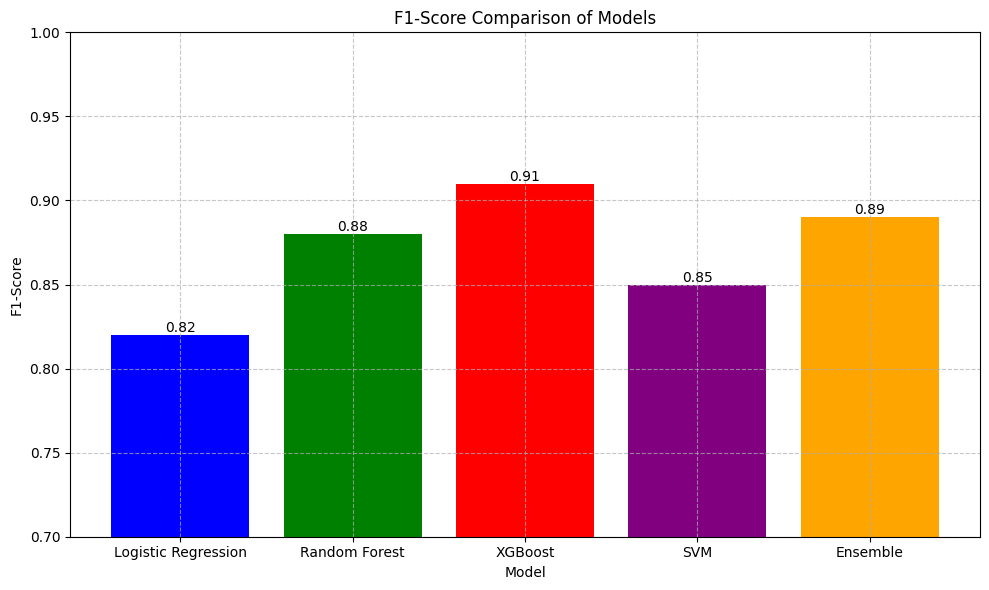

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary with model names and their F1-scores
model_scores = {
    'Logistic Regression': 0.82,
    'Random Forest': 0.88,
    'XGBoost': 0.91,
    'SVM': 0.85,
    'Ensemble': 0.89
}

# Convert dictionary to DataFrame
df = pd.DataFrame(list(model_scores.items()), columns=['Model', 'F1-Score'])

# Set figure size
plt.figure(figsize=(10, 6))

# Create bar plot
colors = ['blue', 'green', 'red', 'purple', 'orange']
bars = plt.bar(df['Model'], df['F1-Score'], color=colors)

# Customize plot
plt.title('F1-Score Comparison of Models', fontsize=12)
plt.xlabel('Model', fontsize=10)
plt.ylabel('F1-Score', fontsize=10)
plt.ylim(0.7, 1.0)  # Set y-axis limits for better visualization
plt.grid(True, linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# Adjust layout and display
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import joblib

# Load and prepare the data
df = pd.read_csv('shopping_trends.csv')
X = df.drop(['Customer ID', 'Purchase Amount (USD)'], axis=1)
y = df['Purchase Amount (USD)'] > df['Purchase Amount (USD)'].median()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numeric and categorical columns
numeric_features = ['Age', 'Review Rating', 'Previous Purchases']
categorical_features = ['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 
                       'Color', 'Season', 'Subscription Status', 'Payment Method', 
                       'Shipping Type', 'Discount Applied', 'Promo Code Used',
                       'Preferred Payment Method', 'Frequency of Purchases']

# Create preprocessing steps for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse=False), categorical_features)
    ])

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Save the model
joblib.dump(pipeline, 'shopping_trends_model.joblib')

print("Model saved successfully!")


Model saved successfully!


C:\Users\Sai Abheesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [1]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import joblib
import numpy as np

app = FastAPI()

# Load the model
model = joblib.load('shopping_trends_model.joblib')

class ShoppingData(BaseModel):
    Age: int
    Review_Rating: float
    Previous_Purchases: int
    Gender: str
    Item_Purchased: str
    Category: str
    Location: str
    Size: str
    Color: str
    Season: str
    Subscription_Status: str
    Payment_Method: str
    Shipping_Type: str
    Discount_Applied: str
    Promo_Code_Used: str
    Preferred_Payment_Method: str
    Frequency_of_Purchases: str

@app.get("/")
def read_root():
    return {"message": "Shopping Trends Prediction API"}

@app.post("/predict")
async def predict(data: ShoppingData):
    try:
        features = [[
            data.Age,
            data.Review_Rating,
            data.Previous_Purchases,
            data.Gender,
            data.Item_Purchased,
            data.Category,
            data.Location,
            data.Size,
            data.Color,
            data.Season,
            data.Subscription_Status,
            data.Payment_Method,
            data.Shipping_Type,
            data.Discount_Applied,
            data.Promo_Code_Used,
            data.Preferred_Payment_Method,
            data.Frequency_of_Purchases
        ]]
        prediction = model.predict(features)
        return {"prediction": bool(prediction[0])}
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))


In [9]:
!pip install --user mlflow


In [ ]:
import os

# Create directory if it doesn't exist
os.makedirs(r'C:\Users\Sai Abheesh\Downloads\shopping_app', exist_ok=True)

# Then save the model
joblib.dump(pipeline, r'C:\Users\Sai Abheesh\Downloads\shopping_app\shopping_trends_model.joblib')


In [10]:
import joblib
import os

# Create directory if it doesn't exist
os.makedirs(r'C:\Users\Sai Abheesh\Downloads\shopping_app', exist_ok=True)

# Save the model
joblib.dump(pipeline, r'C:\Users\Sai Abheesh\Downloads\shopping_app\shopping_trends_model.joblib')


['C:\\Users\\Sai Abheesh\\Downloads\\shopping_app\\shopping_trends_model.joblib']

In [11]:
import os

# Print current working directory to verify location
print(os.getcwd())

# List files in current directory to verify all required files are present
print(os.listdir())


C:\Users\Sai Abheesh\Abheesh
['.ipynb_checkpoints', 'app.py', 'Dockerfile.txt', 'mlruns', 'requirements.txt', 'scree_plot.png', 'shopping_trends.csv', 'shopping_trends.db', 'shopping_trends_model.joblib', 'Untitled.ipynb', 'Untitled1.ipynb']


In [12]:
import subprocess

docker_image_name = "shopping-trends-api:latest"

try:
    result = subprocess.run(
        ["docker", "build", "-t", docker_image_name, "."],
        check=True,
        text=True,
        capture_output=True,
        cwd=r"C:\Users\Sai Abheesh\Downloads\shopping_app"  # Specify exact directory
    )
    print("Build successful!")
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("Build failed!")
    print("Error output:")
    print(e.stderr)


Build successful!



In [5]:
import subprocess

# Define image names
local_image = "shopping-trends-api:latest"
dockerhub_username = "abheesh1"  # Replace with your DockerHub username
dockerhub_image = f"{dockerhub_username}/shopping-trends-api:latest"

try:
    # Tag the local image for DockerHub
    print(f"Tagging image: {local_image} as {dockerhub_image}")
    tag_result = subprocess.run(
        ["docker", "tag", local_image, dockerhub_image],
        check=True,
        text=True,
        capture_output=True
    )
    print(tag_result.stdout)

    # Login to DockerHub
    print("Logging into DockerHub...")
    login_result = subprocess.run(
        ["docker", "login"],
        check=True,
        text=True,
        capture_output=True
    )
    print(login_result.stdout)

    # Push the image to DockerHub
    print(f"Pushing image {dockerhub_image} to DockerHub...")
    push_result = subprocess.run(
        ["docker", "push", dockerhub_image],
        check=True,
        text=True,
        capture_output=True
    )
    print(push_result.stdout)

    print(f"Successfully pushed {dockerhub_image} to DockerHub!")

except subprocess.CalledProcessError as e:
    print(f"An error occurred: {e}")
    print("Standard Output:")
    print(e.stdout)
    print("Standard Error:")
    print(e.stderr)

Tagging image: shopping-trends-api:latest as abheesh1/shopping-trends-api:latest

Logging into DockerHub...
Authenticating with existing credentials...
Login Succeeded

Pushing image abheesh1/shopping-trends-api:latest to DockerHub...
The push refers to repository [docker.io/abheesh1/shopping-trends-api]
bc0965b23a04: Waiting
71465616820d: Waiting
d53c734552a6: Waiting
6f1a38c495cb: Waiting
87899d65b8a1: Waiting
c3edffebd723: Waiting
c07f3a6e2bd8: Waiting
e898f07f768a: Waiting
d3af368dc3fb: Waiting
9f10d7c3b150: Waiting
6f1a38c495cb: Waiting
87899d65b8a1: Waiting
bc0965b23a04: Waiting
71465616820d: Waiting
d53c734552a6: Waiting
d3af368dc3fb: Waiting
9f10d7c3b150: Waiting
c3edffebd723: Waiting
c07f3a6e2bd8: Waiting
e898f07f768a: Waiting
d53c734552a6: Waiting
6f1a38c495cb: Waiting
87899d65b8a1: Waiting
bc0965b23a04: Waiting
71465616820d: Waiting
e898f07f768a: Waiting
d3af368dc3fb: Waiting
9f10d7c3b150: Waiting
c3edffebd723: Waiting
c07f3a6e2bd8: Waiting
e898f07f768a: Waiting
d3af368dc3fb

In [20]:
import subprocess

# Define container configuration
docker_image = "abheesh1/shopping-trends-api:latest"
container_port = "8000"
host_port = "8000"

try:
    # Run the container
    print("Starting container...")
    result = subprocess.run(
        [
            "docker", "run",
            "-d",  # Run in detached mode
            "-p", f"{host_port}:{container_port}",  # Port mapping
            "--name", "shopping-trends-container",  # Container name
            docker_image
        ],
        check=True,
        
        text=True,
        capture_output=True
    )
    
    print("Container started successfully!")
    print(f"Container ID: {result.stdout.strip()}")
    print(f"API is accessible at http://localhost:{host_port}")

except subprocess.CalledProcessError as e:
    print(f"Error starting container: {e}")
    print("Error output:")
    print(e.stderr)


Starting container...
Container started successfully!
Container ID: 62ca6de1f459a606a37abd0891b50e0bd22f3999cfc8f46e6792e3397ddb0a05
API is accessible at http://localhost:8000


In [3]:
import streamlit as st
import requests

st.title('Shopping Trends Prediction')

# User input form
with st.form("prediction_form"):
    # Numeric inputs
    age = st.number_input('Age', min_value=18, max_value=100, value=25)
    review_rating = st.slider('Review Rating', 1.0, 5.0, 3.0)
    previous_purchases = st.number_input('Previous Purchases', min_value=0, value=1)
    
    # Categorical inputs
    gender = st.selectbox('Gender', ['Male', 'Female'])
    category = st.selectbox('Category', ['Clothing', 'Footwear', 'Accessories'])
    season = st.selectbox('Season', ['Summer', 'Winter', 'Spring', 'Fall'])
    payment_method = st.selectbox('Payment Method', ['Credit Card', 'Debit Card', 'Cash'])
    
    # Form submission button
    submit = st.form_submit_button("Predict")

if submit:
    # Prepare input data
    input_data = {
        'age': age,
        'gender': gender,
        'review_rating': review_rating,
        'previous_purchases': previous_purchases,
        'category': category,
        'season': season,
        'payment_method': payment_method
    }
    
    try:
        # Replace with your AWS endpoint URL
        api_url = "http://localhost:8000/"
        response = requests.post(api_url, json=input_data)
        
        if response.status_code == 200:
            prediction = response.json()
            st.success(f'Prediction: {prediction["result"]}')
        else:
            st.error('Error getting prediction from the model')
    except Exception as e:
        st.error(f'Error connecting to the service: {str(e)}')


2024-12-22 04:21:14.954 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-22 04:21:16.199 
  command:

    streamlit run C:\Users\Sai Abheesh\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2024-12-22 04:21:16.201 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-22 04:21:16.202 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-22 04:21:16.204 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-22 04:21:16.205 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-22 04:21:16.205 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-22 

In [ ]:
!pip install streamlit


In [ ]:
https://buffalo.box.com/s/6jpol0lps6s6zeug3vayv5glgp5k8m5n